# STEP 1: IMPORT ALL REQUIRED LIBRARIES

In [1]:
print("="*80)
print("STEP 1: IMPORTING LIBRARIES")
print("="*80)

# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Sklearn - Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# Sklearn - Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

# Sklearn - Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, auc, mean_squared_error, mean_absolute_error,
                             r2_score)
from sklearn.preprocessing import label_binarize

# Model Persistence
import joblib
import pickle

# XGBoost
try:
    from xgboost import XGBClassifier, XGBRegressor
    XGBOOST_AVAILABLE = True
    print("✓ XGBoost available")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠ Installing XGBoost...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'xgboost'])
    from xgboost import XGBClassifier, XGBRegressor
    XGBOOST_AVAILABLE = True
    print("✓ XGBoost installed")

# Statistical tests
from scipy import stats
from scipy.stats import chi2_contingency

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("\n✓ All libraries imported successfully!")

STEP 1: IMPORTING LIBRARIES
✓ XGBoost available

✓ All libraries imported successfully!


# STEP 2: GENERATE SYNTHETIC DATA (WITH MULTIPLE TARGETS)

In [2]:
print("\n" + "="*80)
print("STEP 2: GENERATING SYNTHETIC DATA")
print("="*80)

def generate_fitness_data(n_samples=5000):
    """
    Generate realistic synthetic fitness data with MULTIPLE targets

    Features:
    - Demographics: age, gender, height, weight, body_fat
    - Strength: bench_press, squat, deadlift
    - Activity: daily_steps, training_experience
    - Goals: muscle_gain, fat_loss, strength, general_fitness

    Targets (6):
    1. training_split (Classification)
    2. training_days (Regression)
    3. weekly_volume (Regression)
    4. intensity (Regression)
    5. cardio_minutes (Regression)
    6. expected_strength_gain (Regression)
    """

    data = []

    for i in range(n_samples):
        # Basic demographics
        age = np.random.randint(18, 65)
        gender = np.random.choice(['Male', 'Female'], p=[0.52, 0.48])

        # Physical metrics (gender-specific)
        if gender == 'Male':
            height = np.random.normal(175, 7)
            weight = np.random.normal(80, 12)
            body_fat = np.random.normal(18, 5)
        else:
            height = np.random.normal(163, 6)
            weight = np.random.normal(65, 10)
            body_fat = np.random.normal(25, 5)

        # Ensure realistic ranges
        height = np.clip(height, 150, 200)
        weight = np.clip(weight, 45, 150)
        body_fat = np.clip(body_fat, 8, 40)

        # Training experience (0-20 years)
        training_exp = np.random.choice(
            [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 15, 20],
            p=[0.15, 0.12, 0.10, 0.10, 0.09, 0.08, 0.07, 0.06, 0.05, 0.08, 0.05, 0.03, 0.02]
        )

        # Strength levels (based on gender, weight, and experience)
        strength_base = 1.0 if gender == 'Male' else 0.65
        exp_factor = min(1.5, 0.5 + (training_exp * 0.08))

        bench_press = weight * np.random.uniform(0.6, 1.3) * strength_base * exp_factor
        squat = weight * np.random.uniform(0.8, 1.8) * strength_base * exp_factor
        deadlift = weight * np.random.uniform(1.0, 2.0) * strength_base * exp_factor

        # Ensure realistic ranges
        bench_press = np.clip(bench_press, 20, 250)
        squat = np.clip(squat, 30, 350)
        deadlift = np.clip(deadlift, 40, 400)

        # Daily steps
        daily_steps = np.random.choice(
            [2000, 3000, 4000, 5000, 6000, 7000, 8000, 10000, 12000, 15000],
            p=[0.05, 0.08, 0.12, 0.15, 0.15, 0.15, 0.12, 0.10, 0.05, 0.03]
        )

        # Goals (can have multiple)
        goals = []
        if np.random.random() > 0.6: goals.append('muscle_gain')
        if np.random.random() > 0.7: goals.append('fat_loss')
        if np.random.random() > 0.5: goals.append('strength')
        if np.random.random() > 0.8: goals.append('general_fitness')

        if not goals:
            goals.append(np.random.choice(['muscle_gain', 'strength', 'fat_loss', 'general_fitness']))

        # Derived features
        bmi = weight / ((height / 100) ** 2)
        total_lifted = bench_press + squat + deadlift
        strength_to_weight = total_lifted / weight

        # ====================================================================
        # TARGET 1: TRAINING DAYS (Regression: 3-6 days)
        # ====================================================================
        if 'strength' in goals or 'muscle_gain' in goals:
            if training_exp >= 3:
                training_days = np.random.choice([4, 5, 6], p=[0.2, 0.5, 0.3])
            else:
                training_days = np.random.choice([3, 4, 5], p=[0.3, 0.5, 0.2])
        else:
            training_days = np.random.choice([3, 4, 5], p=[0.4, 0.4, 0.2])

        # ====================================================================
        # TARGET 2: TRAINING SPLIT (Classification: 4 classes)
        # ====================================================================
        split_score = {'PPL': 0, 'Upper_Lower': 0, 'Full_Body': 0, 'Bro_Split': 0}

        # Training frequency influence
        if training_days >= 6:
            split_score['PPL'] += 40
            split_score['Bro_Split'] += 30
        elif training_days == 5:
            split_score['PPL'] += 35
            split_score['Bro_Split'] += 25
            split_score['Upper_Lower'] += 20
        elif training_days == 4:
            split_score['Upper_Lower'] += 40
            split_score['PPL'] += 25
        else:
            split_score['Full_Body'] += 50
            split_score['Upper_Lower'] += 30

        # Experience influence
        if training_exp >= 5:
            split_score['PPL'] += 20
            split_score['Bro_Split'] += 15
        elif training_exp >= 2:
            split_score['Upper_Lower'] += 20
            split_score['PPL'] += 15
        else:
            split_score['Full_Body'] += 30

        # Goals influence
        if 'muscle_gain' in goals:
            split_score['PPL'] += 15
            split_score['Bro_Split'] += 10
        if 'strength' in goals:
            split_score['Upper_Lower'] += 15
            split_score['Full_Body'] += 10
        if 'general_fitness' in goals:
            split_score['Full_Body'] += 20

        # Age influence
        if age > 40:
            split_score['Upper_Lower'] += 10
            split_score['Full_Body'] += 10

        # Add randomness
        for split in split_score:
            split_score[split] += np.random.randint(-10, 10)

        training_split = max(split_score, key=split_score.get)

        # ====================================================================
        # TARGET 3: WEEKLY VOLUME (Regression: 10-25 sets)
        # ====================================================================
        if 'muscle_gain' in goals:
            weekly_volume = np.random.randint(15, 25)
        elif 'strength' in goals:
            weekly_volume = np.random.randint(12, 20)
        else:
            weekly_volume = np.random.randint(10, 18)

        # Adjust for experience
        if training_exp >= 5:
            weekly_volume = min(25, weekly_volume + np.random.randint(0, 3))

        # ====================================================================
        # TARGET 4: INTENSITY (Regression: 60-95% of 1RM)
        # ====================================================================
        if 'strength' in goals:
            intensity = np.random.randint(80, 95)
        elif 'muscle_gain' in goals:
            intensity = np.random.randint(65, 85)
        else:
            intensity = np.random.randint(60, 80)

        # Adjust for experience
        if training_exp < 1:
            intensity = max(60, intensity - 10)  # Beginners use lighter weights

        # ====================================================================
        # TARGET 5: CARDIO MINUTES (Regression: 60-240 min/week)
        # ====================================================================
        if 'fat_loss' in goals:
            cardio_minutes = np.random.randint(120, 240)
        elif daily_steps < 5000:
            cardio_minutes = np.random.randint(90, 180)
        else:
            cardio_minutes = np.random.randint(60, 150)

        # Adjust for age (older = more cardio for health)
        if age > 50:
            cardio_minutes = min(240, cardio_minutes + np.random.randint(0, 30))

        # ====================================================================
        # TARGET 6: EXPECTED STRENGTH GAIN (Regression: kg/month)
        # ====================================================================
        base_gain = 3.0 if gender == 'Male' else 2.0
        exp_penalty = max(0.3, 1 - (training_exp * 0.05))  # Veterans gain slower
        age_penalty = max(0.5, 1 - ((age - 25) * 0.01)) if age > 25 else 1.0

        expected_strength_gain = base_gain * exp_penalty * age_penalty

        if 'strength' in goals:
            expected_strength_gain *= 1.3

        # Add some noise
        expected_strength_gain += np.random.uniform(-0.3, 0.3)
        expected_strength_gain = max(0.5, expected_strength_gain)  # Minimum gain

        # ====================================================================
        # Append to dataset
        # ====================================================================
        data.append({
            # Features
            'age': age,
            'gender': gender,
            'height': height,
            'weight': weight,
            'body_fat': body_fat,
            'bench_press': bench_press,
            'squat': squat,
            'deadlift': deadlift,
            'daily_steps': daily_steps,
            'training_exp': training_exp,
            'bmi': bmi,
            'total_lifted': total_lifted,
            'strength_to_weight': strength_to_weight,
            'goal_muscle_gain': 1 if 'muscle_gain' in goals else 0,
            'goal_fat_loss': 1 if 'fat_loss' in goals else 0,
            'goal_strength': 1 if 'strength' in goals else 0,
            'goal_general_fitness': 1 if 'general_fitness' in goals else 0,

            # Targets (6)
            'training_split': training_split,
            'training_days': training_days,
            'weekly_volume': weekly_volume,
            'intensity': intensity,
            'cardio_minutes': cardio_minutes,
            'expected_strength_gain': expected_strength_gain
        })

    return pd.DataFrame(data)


STEP 2: GENERATING SYNTHETIC DATA


In [3]:
# Generate data
print("\nGenerating fitness training data with multiple targets...")
df = generate_fitness_data(n_samples=5000)
print(f"\n✓ Dataset created successfully!")
print(f"  • Total samples: {len(df)}")
print(f"  • Features: {len([c for c in df.columns if c not in ['training_split', 'training_days', 'weekly_volume', 'intensity', 'cardio_minutes', 'expected_strength_gain']])}")
print(f"  • Targets: 6 (1 classification + 5 regression)")
print(f"\n  First 3 rows:")
print(df.head(3).to_string())


Generating fitness training data with multiple targets...

✓ Dataset created successfully!
  • Total samples: 5000
  • Features: 17
  • Targets: 6 (1 classification + 5 regression)

  First 3 rows:
   age  gender      height     weight   body_fat  bench_press       squat   deadlift  daily_steps  training_exp        bmi  total_lifted  strength_to_weight  goal_muscle_gain  goal_fat_loss  goal_strength  goal_general_fitness training_split  training_days  weekly_volume  intensity  cardio_minutes  expected_strength_gain
0   56  Female  166.262459  58.845702  19.010968    20.000000   30.000000  40.000000         7000             0  21.287583     90.000000            1.529424                 0              1              1                     0      Full_Body              5             14         80             188                2.078253
1   32    Male  189.991609  72.446300  20.988602    60.278652   50.284205  95.497755         4000             4  20.070000    206.060612            2.84432

# STEP 3: EXPLORATORY DATA ANALYSIS (EDA)

In [4]:
print("\n" + "="*80)
print("STEP 3: EXPLORATORY DATA ANALYSIS (EDA)")
print("="*80)


STEP 3: EXPLORATORY DATA ANALYSIS (EDA)


In [5]:
# 3.1 Basic Info
print("\n--- 3.1 Dataset Overview ---")
print(f"Shape: {df.shape}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\n✓ No missing values!" if df.isnull().sum().sum() == 0 else "⚠ Missing values detected!")


--- 3.1 Dataset Overview ---
Shape: (5000, 23)

Data Types:
age                         int64
gender                     object
height                    float64
weight                    float64
body_fat                  float64
bench_press               float64
squat                     float64
deadlift                  float64
daily_steps                 int64
training_exp                int64
bmi                       float64
total_lifted              float64
strength_to_weight        float64
goal_muscle_gain            int64
goal_fat_loss               int64
goal_strength               int64
goal_general_fitness        int64
training_split             object
training_days               int64
weekly_volume               int64
intensity                   int64
cardio_minutes              int64
expected_strength_gain    float64
dtype: object

Missing Values:
age                       0
gender                    0
height                    0
weight                    0
body_fat      

In [6]:
# 3.2 Target Variables Distribution
print("\n--- 3.2 Target Variables Analysis ---")

target_cols = ['training_split', 'training_days', 'weekly_volume', 'intensity',
               'cardio_minutes', 'expected_strength_gain']

print("\n1. TRAINING SPLIT (Classification):")
target_dist = df['training_split'].value_counts()
target_pct = df['training_split'].value_counts(normalize=True) * 100
for split, count in target_dist.items():
    print(f"  {split:15s}: {count:4d} ({target_pct[split]:5.2f}%)")

print("\n2. REGRESSION TARGETS - Descriptive Statistics:")
print(df[['training_days', 'weekly_volume', 'intensity', 'cardio_minutes', 'expected_strength_gain']].describe().round(2).to_string())


--- 3.2 Target Variables Analysis ---

1. TRAINING SPLIT (Classification):
  PPL            : 2415 (48.30%)
  Upper_Lower    : 1575 (31.50%)
  Full_Body      :  991 (19.82%)
  Bro_Split      :   19 ( 0.38%)

2. REGRESSION TARGETS - Descriptive Statistics:
       training_days  weekly_volume  intensity  cardio_minutes  expected_strength_gain
count        5000.00        5000.00    5000.00          5000.0                 5000.00
mean            4.49          17.25      78.84           138.4                    1.85
std             0.95           3.63       9.64            45.6                    0.74
min             3.00          10.00      60.00            60.0                    0.50
25%             4.00          15.00      71.00           103.0                    1.31
50%             5.00          17.00      80.00           133.0                    1.78
75%             5.00          20.00      87.00           168.0                    2.33
max             6.00          25.00      94.00 


✓ Saved: target_distributions.png


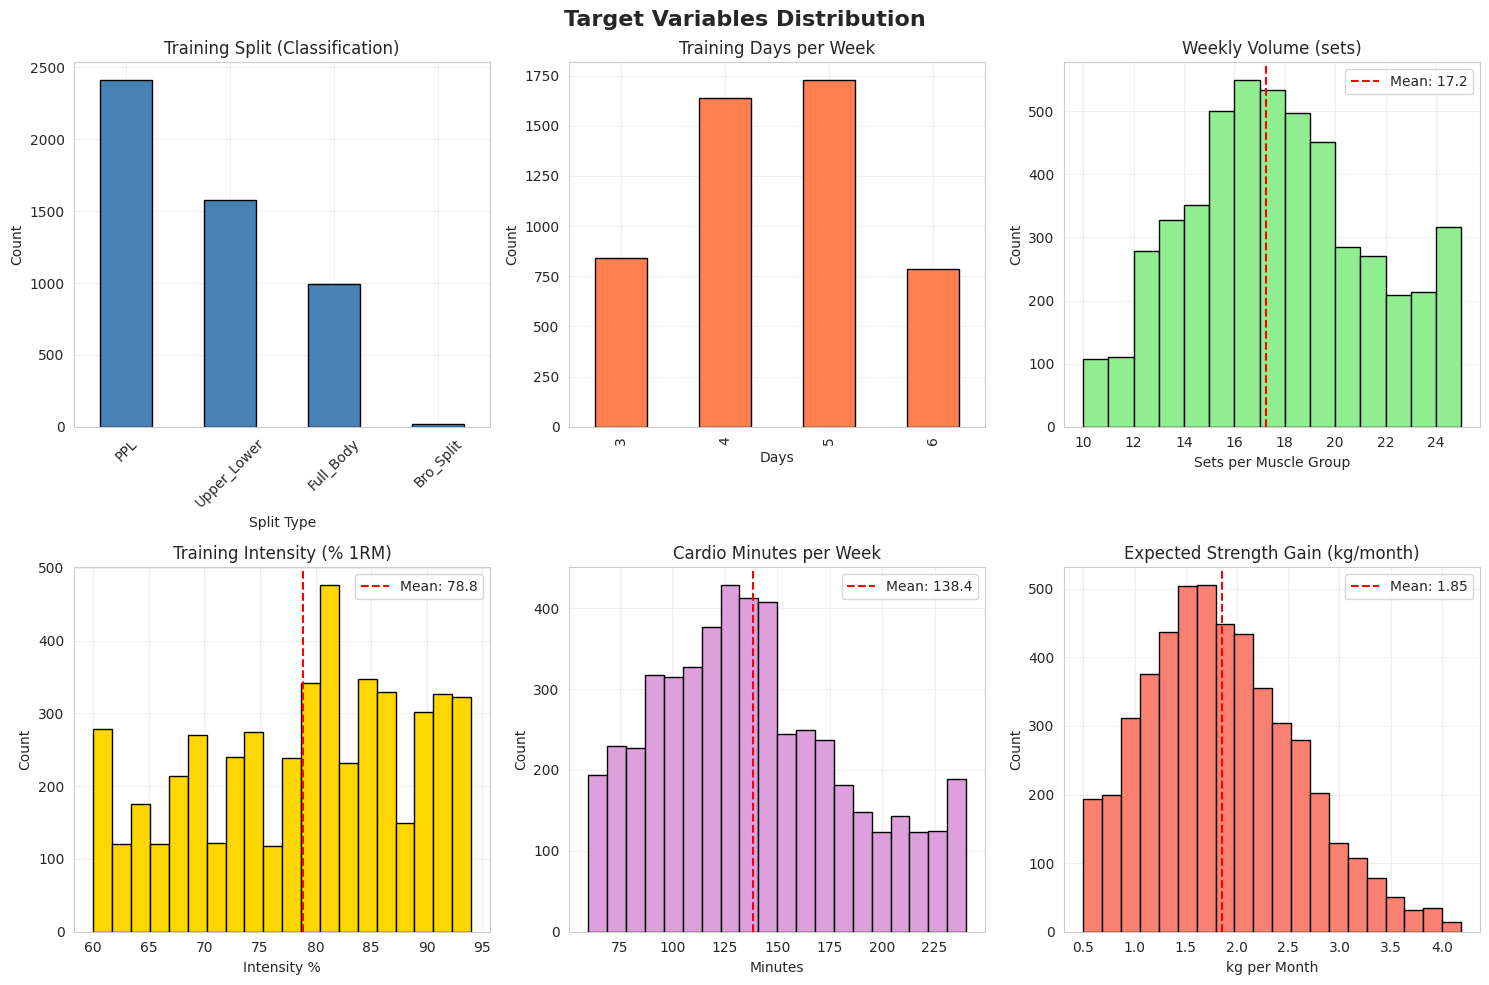

In [7]:
# Visualize all targets
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Target Variables Distribution', fontsize=16, fontweight='bold')

# Training Split
ax = axes[0, 0]
df['training_split'].value_counts().plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('Training Split (Classification)')
ax.set_xlabel('Split Type')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)
ax.grid(alpha=0.3)

# Training Days
ax = axes[0, 1]
df['training_days'].value_counts().sort_index().plot(kind='bar', ax=ax, color='coral', edgecolor='black')
ax.set_title('Training Days per Week')
ax.set_xlabel('Days')
ax.set_ylabel('Count')
ax.grid(alpha=0.3)

# Weekly Volume
ax = axes[0, 2]
ax.hist(df['weekly_volume'], bins=15, color='lightgreen', edgecolor='black')
ax.set_title('Weekly Volume (sets)')
ax.set_xlabel('Sets per Muscle Group')
ax.set_ylabel('Count')
ax.axvline(df['weekly_volume'].mean(), color='red', linestyle='--', label=f"Mean: {df['weekly_volume'].mean():.1f}")
ax.legend()
ax.grid(alpha=0.3)

# Intensity
ax = axes[1, 0]
ax.hist(df['intensity'], bins=20, color='gold', edgecolor='black')
ax.set_title('Training Intensity (% 1RM)')
ax.set_xlabel('Intensity %')
ax.set_ylabel('Count')
ax.axvline(df['intensity'].mean(), color='red', linestyle='--', label=f"Mean: {df['intensity'].mean():.1f}")
ax.legend()
ax.grid(alpha=0.3)

# Cardio Minutes
ax = axes[1, 1]
ax.hist(df['cardio_minutes'], bins=20, color='plum', edgecolor='black')
ax.set_title('Cardio Minutes per Week')
ax.set_xlabel('Minutes')
ax.set_ylabel('Count')
ax.axvline(df['cardio_minutes'].mean(), color='red', linestyle='--', label=f"Mean: {df['cardio_minutes'].mean():.1f}")
ax.legend()
ax.grid(alpha=0.3)

# Expected Strength Gain
ax = axes[1, 2]
ax.hist(df['expected_strength_gain'], bins=20, color='salmon', edgecolor='black')
ax.set_title('Expected Strength Gain (kg/month)')
ax.set_xlabel('kg per Month')
ax.set_ylabel('Count')
ax.axvline(df['expected_strength_gain'].mean(), color='red', linestyle='--', label=f"Mean: {df['expected_strength_gain'].mean():.2f}")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('target_distributions.png', dpi=150, bbox_inches='tight')
print("\n✓ Saved: target_distributions.png")
plt.show()


--- 3.3 Correlation Analysis ---
✓ Saved: correlation_matrix.png


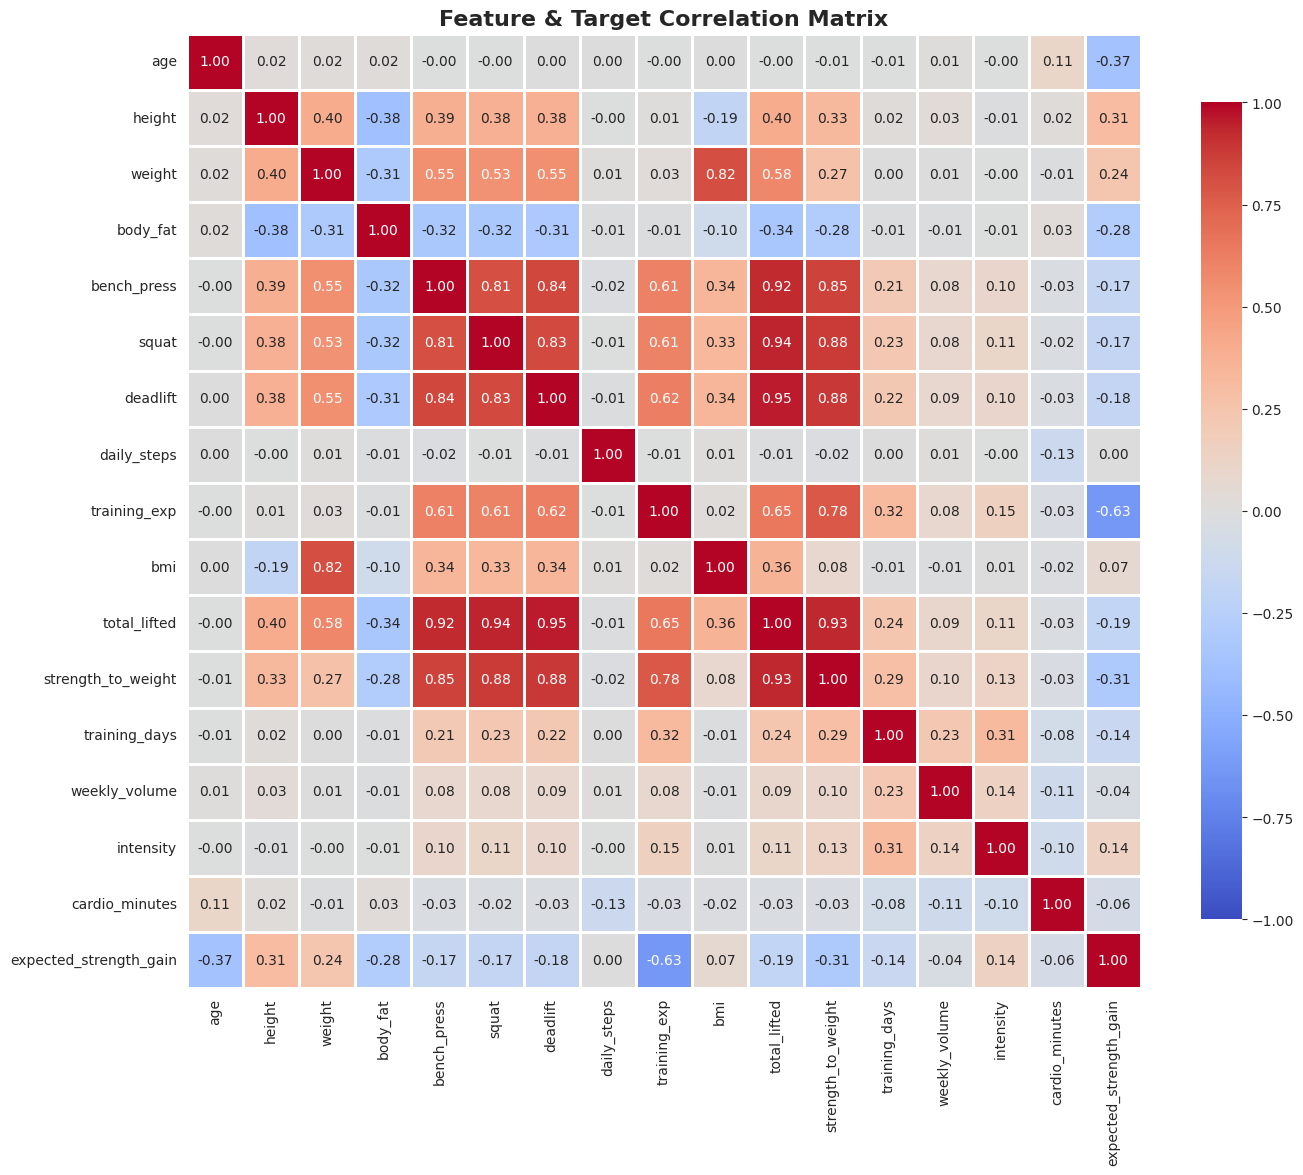

In [8]:
# 3.3 Correlation Analysis
print("\n--- 3.3 Correlation Analysis ---")

numerical_cols = ['age', 'height', 'weight', 'body_fat', 'bench_press', 'squat',
                  'deadlift', 'daily_steps', 'training_exp', 'bmi', 'total_lifted',
                  'strength_to_weight', 'training_days', 'weekly_volume', 'intensity',
                  'cardio_minutes', 'expected_strength_gain']

plt.figure(figsize=(14, 12))
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
plt.title('Feature & Target Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
print("✓ Saved: correlation_matrix.png")
plt.show()

In [9]:
print("\n" + "="*80)
print("EDA COMPLETE - Ready for preprocessing!")
print("="*80)


EDA COMPLETE - Ready for preprocessing!


# STEP 4: DATA PREPROCESSING & SPLIT

In [10]:
# 4.1 Separate features and targets
print("\n--- 4.1 Separating Features and Targets ---")

feature_cols = ['age', 'height', 'weight', 'body_fat', 'bench_press', 'squat',
                'deadlift', 'daily_steps', 'training_exp', 'bmi', 'total_lifted',
                'strength_to_weight', 'goal_muscle_gain', 'goal_fat_loss',
                'goal_strength', 'goal_general_fitness', 'gender']

X = df[feature_cols].copy()

# Targets
y_split = df['training_split'].copy()
y_days = df['training_days'].copy()
y_volume = df['weekly_volume'].copy()
y_intensity = df['intensity'].copy()
y_cardio = df['cardio_minutes'].copy()
y_gain = df['expected_strength_gain'].copy()

print(f"Features shape: {X.shape}")
print(f"Targets: 6 separate variables")



--- 4.1 Separating Features and Targets ---
Features shape: (5000, 17)
Targets: 6 separate variables


In [11]:
# 4.2 Encode categorical variables
print("\n--- 4.2 Encoding Categorical Variables ---")

X['gender_encoded'] = X['gender'].map({'Male': 1, 'Female': 0})
X = X.drop('gender', axis=1)

print(f"✓ Gender encoded")
print(f"Final features: {list(X.columns)}")

# Encode classification target
le_split = LabelEncoder()
y_split_encoded = le_split.fit_transform(y_split)

print(f"\n✓ Training split encoded:")
for idx, class_name in enumerate(le_split.classes_):
    print(f"  {class_name}: {idx}")



--- 4.2 Encoding Categorical Variables ---
✓ Gender encoded
Final features: ['age', 'height', 'weight', 'body_fat', 'bench_press', 'squat', 'deadlift', 'daily_steps', 'training_exp', 'bmi', 'total_lifted', 'strength_to_weight', 'goal_muscle_gain', 'goal_fat_loss', 'goal_strength', 'goal_general_fitness', 'gender_encoded']

✓ Training split encoded:
  Bro_Split: 0
  Full_Body: 1
  PPL: 2
  Upper_Lower: 3


In [12]:
X.head()

,age,height,weight,body_fat,bench_press,squat,deadlift,daily_steps,training_exp,bmi,total_lifted,strength_to_weight,goal_muscle_gain,goal_fat_loss,goal_strength,goal_general_fitness,gender_encoded
0,56,166.262459,58.845702,19.010968,20.000000,30.000000,40.000000,7000,0,21.287583,90.000000,1.529424,0,1,1,0,0
1,32,189.991609,72.446300,20.988602,60.278652,50.284205,95.497755,4000,4,20.070000,206.060612,2.844322,0,1,1,1,1
2,31,178.962790,71.546559,11.110303,40.046567,105.749841,93.352427,5000,5,22.338976,239.148836,3.342562,1,1,0,0,1
3,62,172.528183,86.985474,22.438742,105.103034,80.590939,125.256792,3000,7,29.223123,310.950765,3.574744,1,0,0,0,1
4,31,157.397423,72.842082,21.925621,25.969576,59.414539,51.692608,7000,3,29.402693,137.076722,1.881834,1,0,1,0,0


In [13]:
# 4.3 Train-Test Split (Stratified for classification target)
print("\n--- 4.3 Train-Test Split ---")

X_train, X_test, y_split_train, y_split_test = train_test_split(
    X, y_split_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_split_encoded
)

# Split other targets using same indices
_, _, y_days_train, y_days_test = train_test_split(
    X, y_days, test_size=0.2, random_state=RANDOM_STATE, stratify=y_split_encoded
)
_, _, y_volume_train, y_volume_test = train_test_split(
    X, y_volume, test_size=0.2, random_state=RANDOM_STATE, stratify=y_split_encoded
)
_, _, y_intensity_train, y_intensity_test = train_test_split(
    X, y_intensity, test_size=0.2, random_state=RANDOM_STATE, stratify=y_split_encoded
)
_, _, y_cardio_train, y_cardio_test = train_test_split(
    X, y_cardio, test_size=0.2, random_state=RANDOM_STATE, stratify=y_split_encoded
)
_, _, y_gain_train, y_gain_test = train_test_split(
    X, y_gain, test_size=0.2, random_state=RANDOM_STATE, stratify=y_split_encoded
)

print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Testing set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"✓ All 6 targets split with same indices")



--- 4.3 Train-Test Split ---
Training set: 4000 samples (80.0%)
Testing set: 1000 samples (20.0%)
✓ All 6 targets split with same indices


# STEP 5: SAVE PREPROCESSOR PIPELINE

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✓ Features scaled using StandardScaler")

preprocessor_data = {
    'scaler': scaler,
    'label_encoder_split': le_split,
    'feature_names': list(X.columns),
    'target_names': ['training_split', 'training_days', 'weekly_volume',
                     'intensity', 'cardio_minutes', 'expected_strength_gain'],
    'target_classes': list(le_split.classes_)
}

joblib.dump(preprocessor_data, 'preprocessor_pipeline.pkl')
print(f"✓ Preprocessor pipeline saved: preprocessor_pipeline.pkl")

✓ Features scaled using StandardScaler
✓ Preprocessor pipeline saved: preprocessor_pipeline.pkl


# STEP 6: MODEL COMPARISON (FOR EACH TARGET)

In [15]:
# Define models
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'SVC': SVC(kernel='rbf', random_state=RANDOM_STATE, probability=True),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, eval_metric='mlogloss', verbosity=0)
}

regression_models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=RANDOM_STATE),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=RANDOM_STATE),
    'SVR': SVR(kernel='rbf'),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=RANDOM_STATE, verbosity=0)
}

all_results = {}

In [16]:
# TARGET 1: Training Split (Classification)
print("\n" + "="*80)
print("TARGET 1: TRAINING SPLIT (Classification)")
print("="*80)

results_split = []
for name, model in classification_models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_split_train)

    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    train_f1 = f1_score(y_split_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_split_test, y_test_pred, average='weighted')
    test_acc = accuracy_score(y_split_test, y_test_pred)

    cv_scores = cross_val_score(model, X_train_scaled, y_split_train, cv=5, scoring='f1_weighted')

    results_split.append({
        'Model': name,
        'Train F1': train_f1,
        'Test F1': test_f1,
        'Test Accuracy': test_acc,
        'CV F1 Mean': cv_scores.mean(),
        'Overfitting': train_f1 - test_f1,
        'model_object': model
    })
    print(f"  ✓ Test F1: {test_f1:.4f}")

results_split_df = pd.DataFrame(results_split).sort_values('Test F1', ascending=False)
print("\n" + results_split_df[['Model', 'Train F1', 'Test F1', 'CV F1 Mean', 'Overfitting']].to_string(index=False))
all_results['training_split'] = results_split_df


TARGET 1: TRAINING SPLIT (Classification)
Training Logistic Regression...
  ✓ Test F1: 0.6541
Training SVC...
  ✓ Test F1: 0.6458
Training Naive Bayes...
  ✓ Test F1: 0.5614
Training Random Forest...
  ✓ Test F1: 0.6617
Training Gradient Boosting...
  ✓ Test F1: 0.6780
Training XGBoost...
  ✓ Test F1: 0.6476

              Model  Train F1  Test F1  CV F1 Mean  Overfitting
  Gradient Boosting  0.790199 0.677999    0.684025     0.112200
      Random Forest  1.000000 0.661677    0.673174     0.338323
Logistic Regression  0.624376 0.654124    0.620988    -0.029749
            XGBoost  1.000000 0.647564    0.667343     0.352436
                SVC  0.701911 0.645770    0.656238     0.056142
        Naive Bayes  0.559349 0.561368    0.527720    -0.002018


In [17]:
# TARGET 2-6: Regression Targets
regression_targets = [
    ('training_days', y_days_train, y_days_test, 'Training Days'),
    ('weekly_volume', y_volume_train, y_volume_test, 'Weekly Volume'),
    ('intensity', y_intensity_train, y_intensity_test, 'Intensity'),
    ('cardio_minutes', y_cardio_train, y_cardio_test, 'Cardio Minutes'),
    ('expected_strength_gain', y_gain_train, y_gain_test, 'Expected Strength Gain')
]

for target_name, y_tr, y_te, display_name in regression_targets:
    print("\n" + "="*80)
    print(f"TARGET: {display_name.upper()} (Regression)")
    print("="*80)

    results_reg = []
    for name, model in regression_models.items():
        print(f"Training {name}...")
        model.fit(X_train_scaled, y_tr)

        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        train_r2 = r2_score(y_tr, y_train_pred)
        test_r2 = r2_score(y_te, y_test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_te, y_test_pred))
        test_mae = mean_absolute_error(y_te, y_test_pred)

        cv_scores = cross_val_score(model, X_train_scaled, y_tr, cv=5, scoring='r2')

        results_reg.append({
            'Model': name,
            'Train R2': train_r2,
            'Test R2': test_r2,
            'Test RMSE': test_rmse,
            'Test MAE': test_mae,
            'CV R2 Mean': cv_scores.mean(),
            'Overfitting': train_r2 - test_r2,
            'model_object': model
        })
        print(f"  ✓ Test R2: {test_r2:.4f}")

    results_reg_df = pd.DataFrame(results_reg).sort_values('Test R2', ascending=False)
    print("\n" + results_reg_df[['Model', 'Train R2', 'Test R2', 'Test RMSE', 'CV R2 Mean', 'Overfitting']].to_string(index=False))
    all_results[target_name] = results_reg_df

print("\n" + "="*80)
print("MODEL COMPARISON COMPLETE FOR ALL 6 TARGETS")
print("="*80)


TARGET: TRAINING DAYS (Regression)
Training Linear Regression...
  ✓ Test R2: 0.2342
Training Ridge...
  ✓ Test R2: 0.2342
Training Random Forest...
  ✓ Test R2: 0.4142
Training Gradient Boosting...
  ✓ Test R2: 0.4407
Training SVR...
  ✓ Test R2: 0.3586
Training XGBoost...
  ✓ Test R2: 0.3237

            Model  Train R2  Test R2  Test RMSE  CV R2 Mean  Overfitting
Gradient Boosting  0.511712 0.440731   0.718658    0.428812     0.070981
    Random Forest  0.916288 0.414160   0.735531    0.409371     0.502128
              SVR  0.467888 0.358640   0.769596    0.328033     0.109248
          XGBoost  0.940043 0.323732   0.790262    0.324125     0.616311
            Ridge  0.211491 0.234221   0.840937    0.202984    -0.022730
Linear Regression  0.211492 0.234151   0.840975    0.202944    -0.022659

TARGET: WEEKLY VOLUME (Regression)
Training Linear Regression...
  ✓ Test R2: 0.4746
Training Ridge...
  ✓ Test R2: 0.4746
Training Random Forest...
  ✓ Test R2: 0.4572
Training Gradient Boos

In [18]:
# ============================================================================
# STEP 7: TOP 3 MODELS EVALUATION
# ============================================================================

print("\n" + "="*80)
print("STEP 7: DETAILED EVALUATION OF TOP 3 MODELS (FOR EACH TARGET)")
print("="*80)

top_models_per_target = {}

for target_name, results_df in all_results.items():
    print(f"\n{'='*80}")
    print(f"TARGET: {target_name.upper()}")
    print(f"{'='*80}")

    top_3 = results_df.head(3)

    print(f"\nTop 3 Models:")
    for idx, row in top_3.iterrows():
        metric = row['Test F1'] if 'Test F1' in row else row['Test R2']
        print(f"  {row['Model']}: {metric:.4f}")

    # Store top 3 for later use
    top_models_per_target[target_name] = top_3

    # Detailed evaluation for top model
    best_row = top_3.iloc[0]
    best_model = best_row['model_object']

    print(f"\nBest Model: {best_row['Model']}")
    print(f"Overfitting Gap: {best_row['Overfitting']:.4f}")

    if best_row['Overfitting'] < 0.05:
        print("  ✓ Excellent fit - No overfitting")
    elif best_row['Overfitting'] < 0.10:
        print("  ✓ Good fit - Minimal overfitting")
    else:
        print("  ⚠ Warning - Some overfitting detected")

print("\n" + "="*80)
print("TOP 3 EVALUATION COMPLETE")
print("="*80)

# Select top 2 for each target for hyperparameter tuning
top_2_per_target = {}
for target_name, top_3_df in top_models_per_target.items():
    top_2_per_target[target_name] = top_3_df.head(2)
    print(f"\n{target_name}: Top 2 models selected for tuning")
    for idx, row in top_2_per_target[target_name].iterrows():
        print(f"  • {row['Model']}")



STEP 7: DETAILED EVALUATION OF TOP 3 MODELS (FOR EACH TARGET)

TARGET: TRAINING_SPLIT

Top 3 Models:
  Gradient Boosting: 0.6780
  Random Forest: 0.6617
  Logistic Regression: 0.6541

Best Model: Gradient Boosting
Overfitting Gap: 0.1122
  ⚠ Warning - Some overfitting detected

TARGET: TRAINING_DAYS

Top 3 Models:
  Gradient Boosting: 0.4407
  Random Forest: 0.4142
  SVR: 0.3586

Best Model: Gradient Boosting
Overfitting Gap: 0.0710
  ✓ Good fit - Minimal overfitting

TARGET: WEEKLY_VOLUME

Top 3 Models:
  Gradient Boosting: 0.4825
  Linear Regression: 0.4746
  Ridge: 0.4746

Best Model: Gradient Boosting
Overfitting Gap: 0.0677
  ✓ Good fit - Minimal overfitting

TARGET: INTENSITY

Top 3 Models:
  Gradient Boosting: 0.7227
  Random Forest: 0.7069
  XGBoost: 0.6647

Best Model: Gradient Boosting
Overfitting Gap: 0.0512
  ✓ Good fit - Minimal overfitting

TARGET: CARDIO_MINUTES

Top 3 Models:
  Gradient Boosting: 0.5548
  Random Forest: 0.5377
  Linear Regression: 0.5300

Best Model: G

# STEP 8: HYPERPARAMETER TUNING (TOP 2 FOR EACH TARGET)

In [19]:

print("\n" + "="*80)
print("STEP 8: HYPERPARAMETER TUNING (TOP 2 MODELS FOR EACH TARGET)")
print("="*80)

tuned_models_per_target = {}

# TARGET 1: Training Split (Classification)
print(f"\n{'='*80}")
print("TUNING: TRAINING SPLIT (Classification)")
print(f"{'='*80}")

tuned_split = []
for idx, row in top_2_per_target['training_split'].iterrows():
    model_name = row['Model']
    print(f"\n--- Tuning {model_name} ---")

    if model_name == 'Logistic Regression':
        param_grid = {'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']}
        param_random = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear', 'saga']}
        base_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    elif model_name == 'SVC':
        param_grid = {'C': [0.1, 1, 10], 'kernel': ['rbf', 'poly'], 'gamma': ['scale', 'auto']}
        param_random = {'C': [0.1, 1, 10, 100], 'kernel': ['rbf', 'poly'], 'gamma': ['scale', 'auto', 0.01, 0.1]}
        base_model = SVC(random_state=RANDOM_STATE, probability=True)
    elif model_name == 'Random Forest':
        param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}
        param_random = {'n_estimators': [50, 100, 200, 300], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10]}
        base_model = RandomForestClassifier(random_state=RANDOM_STATE)
    elif model_name == 'Gradient Boosting':
        param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
        param_random = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.05, 0.1, 0.2], 'max_depth': [3, 5, 7]}
        base_model = GradientBoostingClassifier(random_state=RANDOM_STATE)
    elif model_name == 'XGBoost':
        param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
        param_random = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7]}
        base_model = XGBClassifier(random_state=RANDOM_STATE, eval_metric='mlogloss', verbosity=0)
    else:
        param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7]}
        param_random = {'var_smoothing': np.logspace(-10, -6, 20)}
        base_model = GaussianNB()

    grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_split_train)

    random_search = RandomizedSearchCV(base_model, param_random, n_iter=10, cv=5,
                                       scoring='f1_weighted', n_jobs=-1, random_state=RANDOM_STATE)
    random_search.fit(X_train_scaled, y_split_train)

    if grid_search.best_score_ > random_search.best_score_:
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        search_method = "Grid Search"
    else:
        best_model = random_search.best_estimator_
        best_params = random_search.best_params_
        search_method = "Random Search"

    y_test_pred = best_model.predict(X_test_scaled)
    y_train_pred = best_model.predict(X_train_scaled)

    test_f1 = f1_score(y_split_test, y_test_pred, average='weighted')
    train_f1 = f1_score(y_split_train, y_train_pred, average='weighted')

    tuned_split.append({
        'Model': model_name,
        'Search Method': search_method,
        'Best Params': best_params,
        'Test F1': test_f1,
        'Train F1': train_f1,
        'Overfitting': train_f1 - test_f1,
        'model_object': best_model
    })
    print(f"  ✓ Best: {search_method} | Test F1: {test_f1:.4f}")

tuned_models_per_target['training_split'] = pd.DataFrame(tuned_split).sort_values('Test F1', ascending=False)



STEP 8: HYPERPARAMETER TUNING (TOP 2 MODELS FOR EACH TARGET)

TUNING: TRAINING SPLIT (Classification)

--- Tuning Gradient Boosting ---
  ✓ Best: Grid Search | Test F1: 0.6780

--- Tuning Random Forest ---
  ✓ Best: Grid Search | Test F1: 0.6789


Now for regression targets

In [20]:
# Regression Targets
for target_name, top_2_df in top_2_per_target.items():
    if target_name == 'training_split':
        continue

    print(f"\n{'='*80}")
    print(f"TUNING: {target_name.upper()} (Regression)")
    print(f"{'='*80}")

    if target_name == 'training_days':
        y_tr, y_te = y_days_train, y_days_test
    elif target_name == 'weekly_volume':
        y_tr, y_te = y_volume_train, y_volume_test
    elif target_name == 'intensity':
        y_tr, y_te = y_intensity_train, y_intensity_test
    elif target_name == 'cardio_minutes':
        y_tr, y_te = y_cardio_train, y_cardio_test
    else:
        y_tr, y_te = y_gain_train, y_gain_test

    tuned_reg = []
    for idx, row in top_2_df.iterrows():
        model_name = row['Model']
        print(f"\n--- Tuning {model_name} ---")

        if model_name == 'Linear Regression':
            param_grid = {'fit_intercept': [True, False]}
            param_random = {'fit_intercept': [True, False]}
            base_model = LinearRegression()
        elif model_name == 'Ridge':
            param_grid = {'alpha': [0.1, 1.0, 10.0]}
            param_random = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
            base_model = Ridge(random_state=RANDOM_STATE)
        elif model_name == 'Random Forest':
            param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}
            param_random = {'n_estimators': [50, 100, 200, 300], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10]}
            base_model = RandomForestRegressor(random_state=RANDOM_STATE)
        elif model_name == 'Gradient Boosting':
            param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
            param_random = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7]}
            base_model = GradientBoostingRegressor(random_state=RANDOM_STATE)
        elif model_name == 'XGBoost':
            param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
            param_random = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7]}
            base_model = XGBRegressor(random_state=RANDOM_STATE, verbosity=0)
        else:  # SVR
            param_grid = {'C': [0.1, 1, 10], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}
            param_random = {'C': [0.1, 1, 10, 100], 'kernel': ['rbf', 'poly'], 'gamma': ['scale', 'auto', 0.01]}
            base_model = SVR()

        grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_tr)

        random_search = RandomizedSearchCV(base_model, param_random, n_iter=10, cv=5,
                                           scoring='r2', n_jobs=-1, random_state=RANDOM_STATE)
        random_search.fit(X_train_scaled, y_tr)

        if grid_search.best_score_ > random_search.best_score_:
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            search_method = "Grid Search"
        else:
            best_model = random_search.best_estimator_
            best_params = random_search.best_params_
            search_method = "Random Search"

        y_test_pred = best_model.predict(X_test_scaled)
        y_train_pred = best_model.predict(X_train_scaled)

        test_r2 = r2_score(y_te, y_test_pred)
        train_r2 = r2_score(y_tr, y_train_pred)
        test_rmse = np.sqrt(mean_squared_error(y_te, y_test_pred))

        tuned_reg.append({
            'Model': model_name,
            'Search Method': search_method,
            'Best Params': best_params,
            'Test R2': test_r2,
            'Train R2': train_r2,
            'Test RMSE': test_rmse,
            'Overfitting': train_r2 - test_r2,
            'model_object': best_model
        })
        print(f"  ✓ Best: {search_method} | Test R2: {test_r2:.4f}")

    tuned_models_per_target[target_name] = pd.DataFrame(tuned_reg).sort_values('Test R2', ascending=False)

print("\n" + "="*80)
print("HYPERPARAMETER TUNING COMPLETE FOR ALL TARGETS")
print("="*80)


TUNING: TRAINING_DAYS (Regression)

--- Tuning Gradient Boosting ---
  ✓ Best: Random Search | Test R2: 0.4417

--- Tuning Random Forest ---
  ✓ Best: Grid Search | Test R2: 0.4345

TUNING: WEEKLY_VOLUME (Regression)

--- Tuning Gradient Boosting ---
  ✓ Best: Random Search | Test R2: 0.4860

--- Tuning Linear Regression ---
  ✓ Best: Random Search | Test R2: 0.4746

TUNING: INTENSITY (Regression)

--- Tuning Gradient Boosting ---
  ✓ Best: Random Search | Test R2: 0.7227

--- Tuning Random Forest ---
  ✓ Best: Grid Search | Test R2: 0.7167

TUNING: CARDIO_MINUTES (Regression)

--- Tuning Gradient Boosting ---
  ✓ Best: Random Search | Test R2: 0.5640

--- Tuning Random Forest ---
  ✓ Best: Grid Search | Test R2: 0.5507

TUNING: EXPECTED_STRENGTH_GAIN (Regression)

--- Tuning Gradient Boosting ---
  ✓ Best: Random Search | Test R2: 0.9431

--- Tuning Random Forest ---
  ✓ Best: Grid Search | Test R2: 0.9353

HYPERPARAMETER TUNING COMPLETE FOR ALL TARGETS


# STEP 9: FINAL MODEL SELECTION & VALIDATION

In [21]:
print("\n" + "="*80)
print("STEP 9: FINAL MODEL SELECTION & VALIDATION")
print("="*80)

final_models = {}

for target_name, tuned_df in tuned_models_per_target.items():
    print(f"\n{'='*80}")
    print(f"TARGET: {target_name.upper()}")
    print(f"{'='*80}")

    best_row = tuned_df.iloc[0]
    final_model = best_row['model_object']

    print(f"🏆 WINNING MODEL: {best_row['Model']}")
    print(f"Best Parameters: {best_row['Best Params']}")
    print(f"Optimization: {best_row['Search Method']}")

    if 'Test F1' in best_row:
        print(f"Test F1: {best_row['Test F1']:.4f}")
        print(f"Train F1: {best_row['Train F1']:.4f}")
    else:
        print(f"Test R2: {best_row['Test R2']:.4f}")
        print(f"Train R2: {best_row['Train R2']:.4f}")
        print(f"Test RMSE: {best_row['Test RMSE']:.4f}")

    print(f"Overfitting Gap: {best_row['Overfitting']:.4f}")

    # Validation
    if best_row['Overfitting'] < 0.03:
        print("✓ EXCELLENT - No overfitting")
    elif best_row['Overfitting'] < 0.05:
        print("✓ GOOD - Minimal overfitting")
    elif best_row['Overfitting'] < 0.10:
        print("⚠ ACCEPTABLE - Slight overfitting")
    else:
        print("⚠ WARNING - Significant overfitting")

    final_models[target_name] = {
        'model': final_model,
        'model_name': best_row['Model'],
        'best_params': best_row['Best Params'],
        'search_method': best_row['Search Method'],
        'performance': {
            'test_f1': best_row.get('Test F1'),
            'train_f1': best_row.get('Train F1'),
            'test_r2': best_row.get('Test R2'),
            'train_r2': best_row.get('Train R2'),
            'test_rmse': best_row.get('Test RMSE'),
            'overfitting': best_row['Overfitting']
        }
    }



STEP 9: FINAL MODEL SELECTION & VALIDATION

TARGET: TRAINING_SPLIT
🏆 WINNING MODEL: Random Forest
Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Optimization: Grid Search
Test F1: 0.6789
Train F1: 0.9028
Overfitting Gap: 0.2239
⚠ WARNING - Significant overfitting

TARGET: TRAINING_DAYS
🏆 WINNING MODEL: Gradient Boosting
Best Parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.05}
Optimization: Random Search
Test R2: 0.4417
Train R2: 0.4534
Test RMSE: 0.7180
Overfitting Gap: 0.0117
✓ EXCELLENT - No overfitting

TARGET: WEEKLY_VOLUME
🏆 WINNING MODEL: Gradient Boosting
Best Parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.05}
Optimization: Random Search
Test R2: 0.4860
Train R2: 0.4941
Test RMSE: 2.6230
Overfitting Gap: 0.0082
✓ EXCELLENT - No overfitting

TARGET: INTENSITY
🏆 WINNING MODEL: Gradient Boosting
Best Parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05}
Optimization: Random Search
Test R2:

# STEP 10: SAVE ALL FINAL MODELS

In [22]:
print("\n" + "="*80)
print("STEP 10: SAVING ALL FINAL MODELS")
print("="*80)

# Create comprehensive model package
model_package = {
    'models': final_models,
    'scaler': scaler,
    'label_encoder_split': le_split,
    'feature_names': list(X.columns),
    'target_names': ['training_split', 'training_days', 'weekly_volume',
                     'intensity', 'cardio_minutes', 'expected_strength_gain'],
    'target_classes': list(le_split.classes_),
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_size': len(df),
    'random_state': RANDOM_STATE
}

# Save with joblib
joblib.dump(model_package, 'final_fitness_models_multi.pkl')
print(f"✓ All models saved: final_fitness_models_multi.pkl")


STEP 10: SAVING ALL FINAL MODELS
✓ All models saved: final_fitness_models_multi.pkl


In [23]:
# Save backup
with open('final_fitness_models_multi_backup.pkl', 'wb') as f:
    pickle.dump(model_package, f)
print(f"✓ Backup saved: final_fitness_models_multi_backup.pkl")

# Save metadata
metadata = {
    'targets': {},
    'training_info': {
        'training_samples': int(len(X_train)),
        'test_samples': int(len(X_test)),
        'features': list(X.columns),
        'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    }
}

for target_name, model_info in final_models.items():
    metadata['targets'][target_name] = {
        'model_name': model_info['model_name'],
        'best_parameters': {k: str(v) for k, v in model_info['best_params'].items()},
        'performance': {k: float(v) if v is not None else None
                       for k, v in model_info['performance'].items()}
    }

import json
with open('model_metadata_multi.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Metadata saved: model_metadata_multi.json")


✓ Backup saved: final_fitness_models_multi_backup.pkl
✓ Metadata saved: model_metadata_multi.json
